## Pycle demo 0: a minimal working example
This notebook provides a quick of Compressive Learning with the `pycle` toolbox. It demonstrates the typical workflow with `pycle` and core features. In particular, we will:

0. Generate a synthetic dataset
1. Sketch it with multiple sketching operators corresponding to a range of sketching scale parameters
2. Use these sketches to estimate the centroids associated with the dataset
3. Return the best result

We assume that `pycle` and its torch requirements have been installed following the documentation.

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pyplot as plt
from loguru import logger
import sys

# Logger made less verbose
logger.remove()
logger.add(sys.stderr, level="WARNING")

# Fix the random seed for reproducibility
seed = 5
np.random.seed(seed)

# Choose torch device
device = torch.device('cpu') # on GPU, use 'cuda:0' in place of 'cpu'

### PART 0: generate a dataset with utils

To demonstrate the toolbox, we generate a simple synthetic dataset, from a Gaussian mixture model in two dimensions.

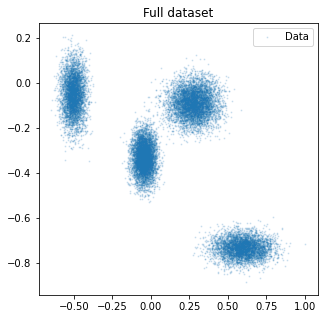

In [2]:
from pycle.utils.datasets import generatedataset_GMM
from pycle.utils.vizualization import simple_plot_clustering

d = 2     # Dimension
K = 4     # Number of Gaussians
n = 20000 # Number of samples we want to generate
# We use the generatedataset_GMM method from pycle (we ask that the entries are <= 1, and imbalanced clusters)
X = generatedataset_GMM(d, K, n, normalize='l_inf-unit-ball', imbalance=1/3, seed=seed).to(device)

# Bounds on the dataset, necessary for compressive k-means
bounds = torch.cat((-torch.ones(1, d),torch.ones(1, d)), 0) # We assumed the data is normalized between -1 and 1

# Visualize the dataset
simple_plot_clustering(X, title="Full dataset")

### PART 1: sketching the dataset
We first compress the dataset as a sketch. All the tools required for this step are located in the `pycle.sketching` submodule. 

In [3]:
from pycle.sketching.frequency_sampling import drawFrequencies
from pycle.sketching.feature_maps.MatrixFeatureMap import MatrixFeatureMap
from pycle.sketching import computeSketch

Recall that the sketch of a dataset $X$ is given by

$$ \boldsymbol z = \sum_{\boldsymbol x_i \in X} \Phi(\boldsymbol x_i) $$

We first generate the feature map $\Phi$. In this simple example, we chose here random Fourier features $\Phi(\boldsymbol x) = \exp(\mathrm{i}\Omega^T\boldsymbol x)$, which is the usual choice for k-means and GMM estimation. In this expression, $\Omega$ is a matrix of $m$ "frequency" vectors, generated from $\boldsymbol \omega_j \sim \Lambda$ (without entering into the details, in this case we pick a Folded Gaussian distribution parametrized by $\Sigma$, which should roughly represent the covariance of the desired clusters). The sketch size $m$ should here be of the order of the number of parameters to estimate, here the number of centroid coordinates, $Kd$.

In [4]:
# Pick the dimension m: 5*K*d is usually (just) enough in clustering (here m = 80)
m = 10*K*d 

# For this simple example, assume we have a priori a rough idea of the size of the clusters 
# (here: isotropic gaussians of variance 0.1)
# this is generally not the case and we will show in an other notebook how to choose Sigma properly
Sigma = 0.1 * torch.eye(d).to(device)

# According to the Folded Gaussian rule, we want m frequencies in dimension d, parametrized by Sigma
# an other, better but more complicated, distribution is the "AdaptedRadius" distribution.
Omega = drawFrequencies("FoldedGaussian", d, m, Sigma).to(device)

# The feature map implementated by the MatrixFeatureMap class is a standard one:
# the complex exponential of projections on Omega^T
# It takes a non-linearity identifier  (or callable) f and a matrix Omega as argument and returns a function:
# Phi(.) = f(Omega @ .)
Phi = MatrixFeatureMap("ComplexExponential", Omega, device=device)

# And sketch X with Phi: we map a 20000x2 dataset to a 80-dimensional complex vector
z = computeSketch(X, Phi, verbose=False)

### PART 2: compressive learning from the sketch
Now that we have computed `z`, we want to learn from this sketch alone. Algorithms that learn from the sketch are  available in the `pycle.compressive_learning` submodule (which we simply refer to as `cl`). 

In [5]:
from pycle.compressive_learning.CLOMP_CKM import CLOMP_CKM

To solve compressive k-means (CKM) with the CLOMP-R algorithm, we create an instance of `cl.CLOMP_CKM`, to which we specify the feature map, the number of centroids we want, the data bounds, and finally the dataset sketch `z`. We then tell the solver to search for the centroids by calling `fit_once()`, and access the found solution as `current_sol` (which returns a tuple with the relative weigths of the clusters, and then the centroids themselves).

In [6]:
# Initialize the solver object
# For compressive kmeans, the number of mixture components is the number of clusters we look for
# the bounds define the bounding box where the centroids can be found
ckm_solver = CLOMP_CKM(Phi, size_mixture_K=K, bounds=bounds, sketch_z=z)

# Launch the CLOMP optimization procedure
# the possible warning about complex values that you get comes from a bug in torch.
ckm_solver.fit_once()

# Get the solution
(centroids, weights) = ckm_solver.current_solution

/home/luc/anaconda3/envs/dict/lib/python3.9/site-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:240.)
  Variable._execution_engine.run_backward(


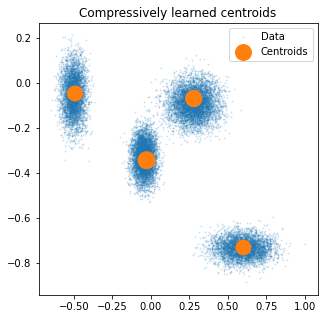

SSE: 174.36924924142286


In [7]:
from pycle.utils.metrics import SSE

simple_plot_clustering(X, centroids, weights, title="Compressively learned centroids")
print("SSE: {}".format(SSE(X,centroids)))

In the above figure, the size of the orange centroid markers is proportional to the weights of the centroids.
As you can see, thanks to `pycle` only a few lines of code suffice to start doing compressive learning. In the next demos, we show how to use some other features of the toolbox, such as automatically setting $\Sigma$, solving other tasks (GMM), and a privacy-preservation layer on top of the sketch, and using quantized sketch contributions.